# Real World Application

## Description of the Problem

El ebola fue por primera vez identificado en 1976 despues de un brote en lo que hoy es la Republica Democratica del Congo, desde entonces, esta clase de virus emergen periodicamente y el virus de ebola es uno de los mas mortales, sin tratamiento el 90% de los casos son fatales [1]. 

Por la mortal que puede llegar a ser, se pretende estudiar sobre un caso de brote de ebola, y generar modelos que puedan predecir datos sobre el numero de casos acumulado, con el objetivo de que pueda servir como herramienta frente a nuevos brotes similares.

Para ello, vamos a tratar de usar 2 metodos para generar modelos que minizan la suma de los errores al cuadrado de las predicciones, vamos a tratar de modelar el problema como una regresion logistica para luego usar el metodo de Gauss-Newton para resolver este problema no lineal de minimos cuadrados, y vamos a modelar el problema como un polinomio para luego usar el metodo de polinomios de minimos cuadrados.

## Data

En 1995 se produjo un brote de la especie Zaire ebolavirus en la ciudad de Kiwkwit y sus alrededores

Se tiene un dataset que contiene una serie de tiempo con los conteos de nuevos individuos que presentan signos clinicos y el numero de nueva eliminaciones de cada dia del brote de Ebola de 1995 en la Republica Democratica del Congo [2].

El dataset es un dataframe con 192 filas y 3 variables:
-   **time** dias desde el 1 de Enero de 1995
-   **clin_signs** numero de nuevos casos clinicos por cada dia
-   **removals** numero de nuevas eliminaciones por cada dia

Aunque se va a modificar el dataset para que `clin_signs` contenga el acumulado de los casos que presentan signos clinicos

> Se va a llamar punto a los pares de (dia, casos reportados hasta tal dia) que contiene el dataset, note que no se utiliza la informacion de la variable `removals` del dataset

## Implementation

### Setup and Configuration

Las siguientes celdas estan dedicadas a preparar el entorno para las implementaciones, especificamente

- **Installar dependencias adicionales:** Instala el paquete rdata, ademas se supone que ya estan instaladas las dependecias del archivo requirements.txt
- **Importar librerias:** jax, rdata, matplotlib, pandas, etc
- **Cargar el dataset:** Cargar ebola.rda en la variable `all_data`, partir `all_data` en `test_data` y `train_data`
- **Configuracion:** configuraciones de jax adecuadas para el notebook

In [1]:
!pip install -q rdata

In [2]:
import rdata
from jax.numpy import sqrt, exp, power, linalg, linspace
import pandas as pd
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
import jax
import random

random.seed(123)
np = jnp
jax.config.update("jax_enable_x64", True) # Enables 64 bits floating point numbers
jax.config.update('jax_debug_nans', True)  # Raise an error if a NaN or Inf appears

In [3]:
parsed = rdata.parser.parse_file('ebola.rda')

# Convierte los objetos cargados a Python
dataframe = rdata.conversion.convert(parsed)
dataframe = next(iter(dataframe.values()))
dataframe['clin_signs'] = dataframe['clin_signs'].cumsum()

all_data = dataframe

In [4]:
percentage = 0.7
k = int(len(all_data) * percentage)
train_ind = random.sample(range(1, 1 + len(all_data)), k)
train_ind.sort()

test_ind = [i for i in range(1, 1 + len(all_data)) if not i in train_ind]

In [5]:
train_data = all_data.loc[train_ind]
test_data = all_data.loc[test_ind]
train_data.head()

,time,clin_signs,removals
1,0,1,0
2,1,1,0
3,2,1,0
4,3,1,0
6,5,1,0


### Gauss-Newton for Non-linear Least Squares problems

In [6]:
def regresion(xi, ai, b0i, b1i):
  """
    Regresion Logistica

    ai -> tope de la grafica
    b0i -> intercepto con el eje x
    b1i -> pendiente con el eje x
  """
  return ai / (1 + exp(-(b0i + b1i*xi)))

def calcular_jacobiano(arr_X, params):
  """
  Calcula el Jacobiano de la función 'regresion' para una lista de valores de xi.
  """
  # Define una función que toma los parámetros (ai, b0i, b1i, ci)
  # y devuelve el valor de la función 'regresion' para un xi dado
  def regresion_para_xi(params):
      return arr_X - regresion(arr_X, *params)

  # Calcula el Jacobiano de 'regresion_para_xi' usando jacfwd
  jacobiano = jacfwd(regresion_para_xi)(params)

  return jacobiano

def vector_residuo(arr_X, arr_Y, B):
  return arr_Y - regresion(arr_X, *B)

In [7]:
def suma_de_errores_cuadrados(arr_X, arr_Y, B):
  vector = vector_residuo(arr_X, arr_Y, B)
  return sum([
      np.power(elem, 2) for elem in vector
  ])

def sanitizar_inversa(matrix, det_tol):
  if linalg.det(matrix) < det_tol:
    return linalg.pinv(matrix)

  return linalg.inv(matrix)

def Gauss_Newton(max_iter, tol, inicio, arr_X, arr_Y, det_tol):
  B = inicio
  valores_iteracion = []

  for i in range(max_iter):
    J = calcular_jacobiano(arr_X, B)
    JtJ_inv = sanitizar_inversa(np.dot(J.T, J), det_tol)
    JtJ_invJt = np.dot(JtJ_inv, J.T)

    B -= np.dot(JtJ_invJt, vector_residuo(arr_X, arr_Y, B))

    temp = suma_de_errores_cuadrados(arr_X, arr_Y, B)

    if i>1:
      if jnp.any(jnp.isnan(temp)): break
      if abs(valores_iteracion[-1] - valores_iteracion[-2]) < tol: break

    valores_iteracion.append(temp)
    print("Iteracion:", i, "\tError Cuadrado:", temp)

  return B, valores_iteracion

### Polynomial Least Squares

Vamos a tratar de modelar el comportamiento del ebola con polinomios de grado n que minimicen la suma de los errores al cuadrado de los puntos del dataset

Con esa intencion se va a ejecutar la funcion `polynomial_least_squares(x, y, x_pred, n)` que evalua $P_n(x_{pred})$, donde 
$$P_n(x) = a_n x^n + \dots + a_1 x + a_0$$
y los coeficientes $a_1, \dots, a_n$ son elejidos de tal manera que minizan la suma de los errores al cuadrado de los puntos del dataset.

In [8]:
def polynomial_least_squares(x, y, x_pred, n, print_polynomial = True):
    """
    Evaluates P_n(x_pred) where P_n is the algebraic polynomial
    P_n(x) = a_n x^n + a_(n-1) x^(n-1) + ... + a_1 x + a_0 of degree n < m - 1
    choosing a_0, ..., a_n to minimize the sum of the squares error of the given points

    Args:
        x (jnp.array) : a list of x_coordinates of points
        y (jnp.array) : a list of y_coordinates of points
        x_pred (float / jnp.array) : the number, or array that contains the values we are going to evaluate P_n(x)
        n (int) : degree of the polynomial

    Returns:
        (int) P_n(x_pred)
    """
    m = len(x) # number of points
    assert n < m - 1
    assert len(x) == len(y), "There are not equal number of x_cords and y_cords"

    # Ap = b will be normal equations written in matrix form
    # where x = (a_0, a_1, ..., a_n)
    A = [[0 for _ in range(n + 1)] for _ in range(n + 1)]
    b = [[0 for _ in range(1)] for _ in range(n + 1)]

    for i in range(n + 1):
        for j in range(n + 1):
            A[i][j] = sum(x[k]**(i + j) for k in range(m + 1))

    for i in range(n + 1):
        b[i] = sum(y[j]*x[j]**i for j in range(m + 1))

    # the solution of x to the system Ax=b will give the constants
    # p = (a_0, a_1, ..., a_n)
    # such that the polynomial P_n(x) = a_n x^n + ... + a_0
    # minimizes the sum of squares error of the given points
    # (Burden, Faires, & Burden, 2015, p. 501) [3]

    p = np.linalg.solve(np.array(A), np.array(b))
    if print_polynomial:
        print(f"P_{n}(x) = " + " + ".join(f"({round(p[i], 2)})x^{i}" for i in range(n + 1)))
    
    # evaluate, p constains the coefficients of the polynomial of degree n
    return sum(p[i]*x_pred**i for i in range(n + 1))

## Visualization

### Estimacion de parametros con Non-linear Least Squares

Iteracion: 0 	Error Cuadrado: 193063.50425339962
Iteracion: 1 	Error Cuadrado: 39940.910272133806
Iteracion: 2 	Error Cuadrado: 6148.916101104976
Iteracion: 3 	Error Cuadrado: 1686.583519524847
Iteracion: 4 	Error Cuadrado: 1606.152682474306
Iteracion: 5 	Error Cuadrado: 1605.5230165227156
Iteracion: 6 	Error Cuadrado: 1605.5189994376735
Iteracion: 7 	Error Cuadrado: 1605.5189742430362
Iteracion: 8 	Error Cuadrado: 1605.5189740854228
Iteracion: 9 	Error Cuadrado: 1605.5189740844392
Resuelto en 10 iteraciones
Respuesta: [ 2.93230234e+02 -1.17840211e+01  9.67431774e-02]


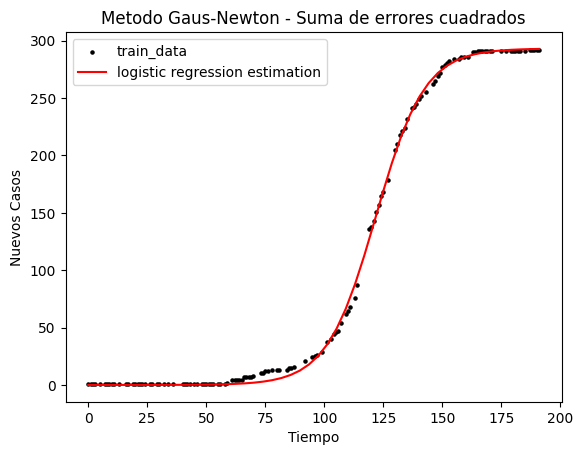

In [9]:
train_X = jnp.array(train_data['time'].values.astype(np.float64))
train_Y = jnp.array(train_data['clin_signs'].values.astype(np.float64))

iteraciones = 50
inicio = jnp.array([300, 1, 0]).astype(np.float64)
det_tol = 1e-12

B, error_gauss = Gauss_Newton(iteraciones, 1e-8, inicio, train_X, train_Y, det_tol)

new_X = linspace(train_X[0], train_X[-1])
new_Y_gauss = regresion(new_X, *B)

plt.scatter(train_X, train_Y, s = 5, color='black', label = "train_data")
plt.plot(new_X, new_Y_gauss, color='red', label="logistic regression estimation")
plt.title(f"Metodo Gaus-Newton - Suma de errores cuadrados")
plt.xlabel('Tiempo')
plt.ylabel('Nuevos Casos')

print("Resuelto en", len(error_gauss), "iteraciones")
print("Respuesta:", B)
plt.legend()
plt.show()

### Predicciones a partir de la estimacion de parametros

In [10]:
test_X = jnp.array(test_data['time'].values.astype(np.float64))
test_Y = jnp.array(test_data['clin_signs'].values.astype(np.float64))   
mse = suma_de_errores_cuadrados(test_X, test_Y, B) / len(test_X)
print("El Mean Squared Error de predecir a partir de la estimacion de parametros es", round(mse, 2))

El Mean Squared Error de predecir a partir de la estimacion de parametros es 16.61


### Predicciones a partir de polinomios

Voy a graficar para n = 1, 2, 3, 4, 5, los polinomios que genera el metodo de polynomial least squares en la misma figura, para visualizar y poder comparar rapidamente entre diferentes valores de n, con graficas parecidas a la anterior

P_1(x) = (-82.60000000000001)x^0 + (2.02)x^1
Then the mean squared error is 2608.35
P_2(x) = (-11.98)x^0 + (-0.23)x^1 + (0.01)x^2
Then the mean squared error is 1073.0
P_3(x) = (45.480000000000004)x^0 + (-3.95)x^1 + (0.06)x^2 + (-0.0)x^3
Then the mean squared error is 743.83
P_4(x) = (-13.0)x^0 + (2.68)x^1 + (-0.1)x^2 + (0.0)x^3 + (-0.0)x^4
Then the mean squared error is 180.62


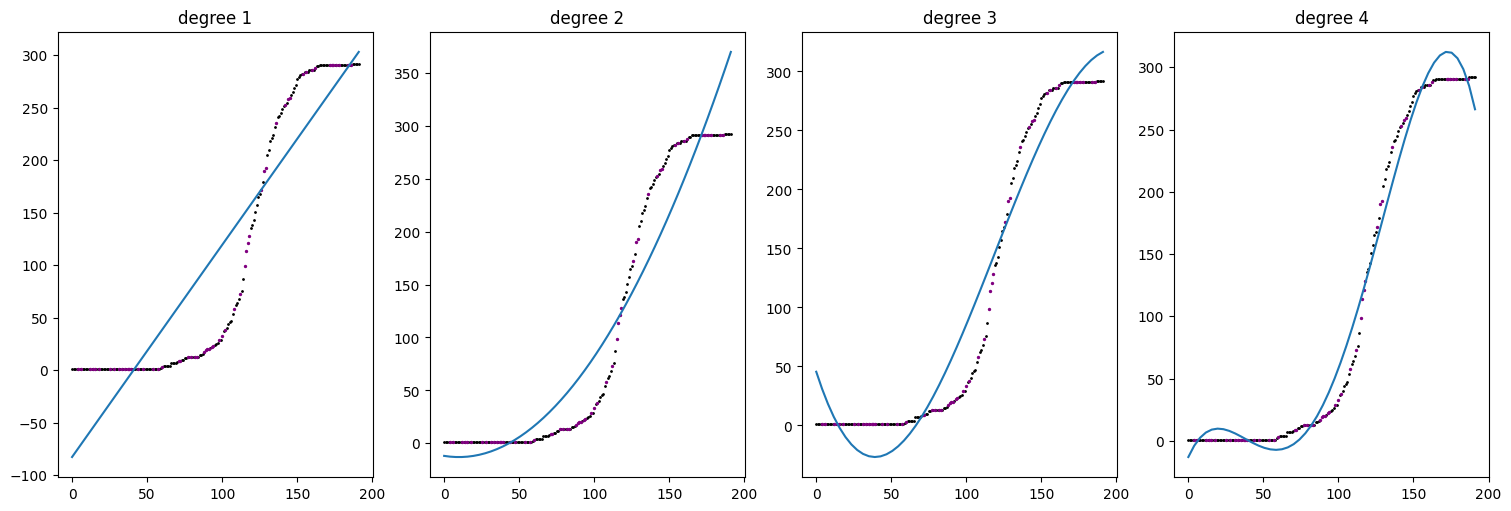

In [11]:
# Retrieve original data
train_X = jnp.array(train_data['time'].values.astype(np.float64))
train_Y = jnp.array(train_data['clin_signs'].values.astype(np.float64))

test_X = jnp.array(test_data['time'].values.astype(np.float64))
test_Y = jnp.array(test_data['clin_signs'].values.astype(np.float64))   

m = 4
fig, axis = plt.subplots(1, m, figsize=(15, 5), constrained_layout=True) # This allows to do multiples plots in the same figure

for n in range(1, m + 1):
    # Do predictions
    x_pred = linspace(min(all_data["time"]), max(all_data["time"])) 
    y_pred =  polynomial_least_squares(train_X, train_Y, x_pred, n)

    r = test_Y - polynomial_least_squares(train_X, train_Y, test_X, n, False)
    squared_error = sum(ri*ri for ri in r)
    mse = squared_error / len(test_Y)
    print(f"Then the mean squared error is {round(mse, 2)}")

    # Plot prediction n at the column n-1
    axis[n - 1].scatter(train_X, train_Y, s=1, color="black", label = "train_data")
    axis[n - 1].scatter(test_X, test_Y, s=2, color="purple", label = "test_data")
    axis[n - 1].plot(x_pred, y_pred, label = f"degree {n} Polynomial aproximation")
    axis[n - 1].set_title(f"degree {n}")

plt.show()

Para n = 1, ..., 6, no se vio ningun problema de overfitting, pero voy visualizar polinomios con grados mas altos

P_14(x) = (0.28)x^0 + (1.92)x^1 + (-0.59)x^2 + (0.07)x^3 + (-0.0)x^4 + (0.0)x^5 + (-0.0)x^6 + (0.0)x^7 + (-0.0)x^8 + (0.0)x^9 + (-0.0)x^10 + (-0.0)x^11 + (0.0)x^12 + (-0.0)x^13 + (0.0)x^14
Then the mean squared error is 14.9
P_17(x) = (-0.26)x^0 + (1.35)x^1 + (-0.26)x^2 + (0.02)x^3 + (-0.0)x^4 + (0.0)x^5 + (-0.0)x^6 + (-0.0)x^7 + (0.0)x^8 + (-0.0)x^9 + (0.0)x^10 + (-0.0)x^11 + (0.0)x^12 + (0.0)x^13 + (-0.0)x^14 + (-0.0)x^15 + (0.0)x^16 + (-0.0)x^17
Then the mean squared error is 9.14
P_18(x) = (-2.23)x^0 + (3.71)x^1 + (-0.78)x^2 + (0.07)x^3 + (-0.0)x^4 + (0.0)x^5 + (-0.0)x^6 + (0.0)x^7 + (-0.0)x^8 + (-0.0)x^9 + (0.0)x^10 + (0.0)x^11 + (-0.0)x^12 + (-0.0)x^13 + (0.0)x^14 + (0.0)x^15 + (-0.0)x^16 + (0.0)x^17 + (-0.0)x^18
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Errores de overflow para el polinomio de grado 18


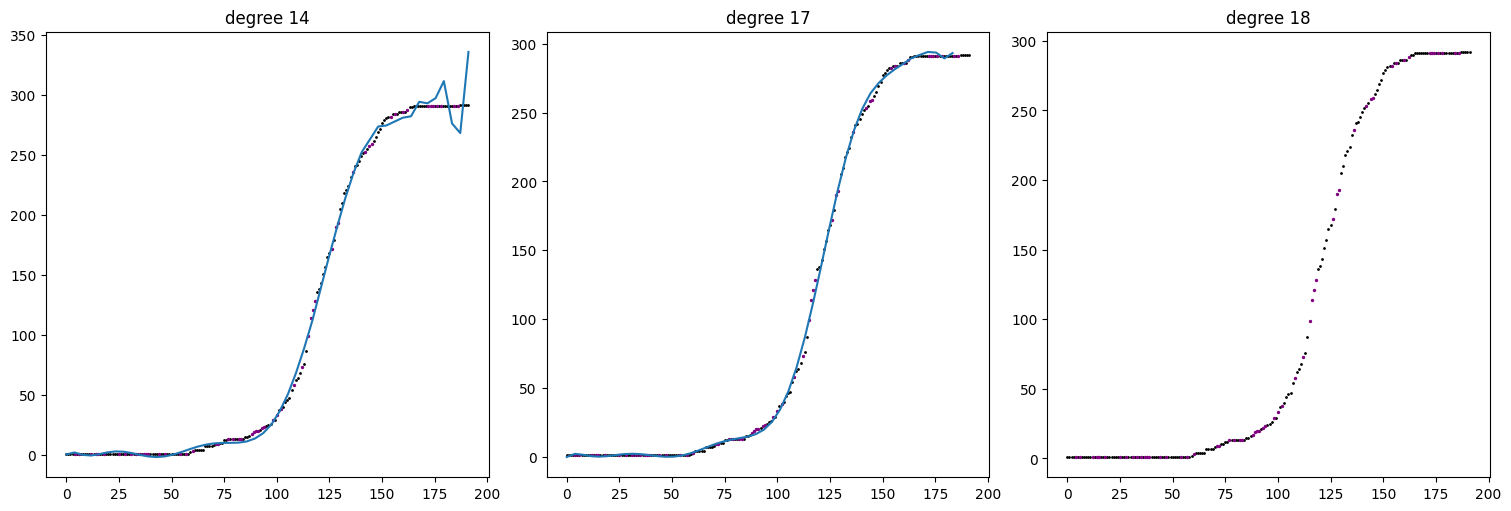

In [12]:
# Retrieve original data
train_X = jnp.array(train_data['time'].values.astype(np.float64))
train_Y = jnp.array(train_data['clin_signs'].values.astype(np.float64))

test_X = jnp.array(test_data['time'].values.astype(np.float64))
test_Y = jnp.array(test_data['clin_signs'].values.astype(np.float64))   

degrees = [14, 17, 18]
m = len(degrees)
fig, axis = plt.subplots(1, m, figsize=(15, 5), constrained_layout=True) # This allows to do multiples plots in the same figure

for n in range(1, m + 1):
    axis[n - 1].scatter(train_X, train_Y, s=1, color="black", label = "train_data")
    axis[n - 1].scatter(test_X, test_Y, s=2, color="purple", label = "test_data")
    axis[n - 1].set_title(f"degree {degrees[n - 1]}")
    try:
        # Do predictions
        x_pred = linspace(min(all_data["time"]), max(all_data["time"])) 
        y_pred =  polynomial_least_squares(train_X, train_Y, x_pred, degrees[n - 1])

        r = test_Y - polynomial_least_squares(train_X, train_Y, test_X, degrees[n - 1], False)
        squared_error = sum(ri*ri for ri in r)
        mse = squared_error / len(test_Y)
        print(f"Then the mean squared error is {round(mse, 2)}")

        # Plot prediction n at the column n-1
        axis[n - 1].plot(x_pred, y_pred, label = f"degree {degrees[n - 1]} Polynomial aproximation")
    except FloatingPointError:
        print(f"Errores de overflow para el polinomio de grado {degrees[n - 1]}")

plt.show()

Note que al aproximar con un polinomio de grado 18, ya se vuelve evidente los problemas de overflow, y se resalta el comportamiento erratico que tiene al final el polinomio de grado 14

#### Visualizacion de ambos enfoques al mismo tiempo

P_17(x) = (-0.26)x^0 + (1.35)x^1 + (-0.26)x^2 + (0.02)x^3 + (-0.0)x^4 + (0.0)x^5 + (-0.0)x^6 + (-0.0)x^7 + (0.0)x^8 + (-0.0)x^9 + (0.0)x^10 + (-0.0)x^11 + (0.0)x^12 + (0.0)x^13 + (-0.0)x^14 + (-0.0)x^15 + (0.0)x^16 + (-0.0)x^17


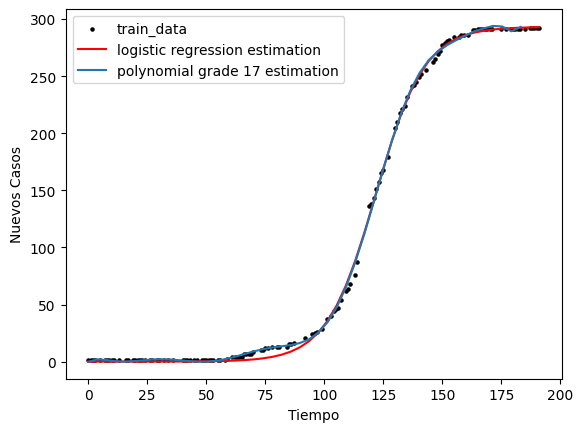

In [13]:
# Retrieve original data
train_X = jnp.array(train_data['time'].values.astype(np.float64))
train_Y = jnp.array(train_data['clin_signs'].values.astype(np.float64))

test_X = jnp.array(test_data['time'].values.astype(np.float64))
test_Y = jnp.array(test_data['clin_signs'].values.astype(np.float64))   

x_pred = linspace(min(all_data["time"]), max(all_data["time"])) 

# Logistic Regression
new_Y_gauss = regresion(x_pred, *B)

# Polynomial
degree = 17
y_pred_polynomial =  polynomial_least_squares(train_X, train_Y, x_pred, degree)

plt.scatter(train_X, train_Y, s = 5, color='black', label = "train_data")
plt.plot(x_pred, new_Y_gauss, color="red", label="logistic regression estimation")
plt.plot(x_pred, y_pred_polynomial, label=f"polynomial grade {17} estimation")
plt.xlabel('Tiempo')
plt.ylabel('Nuevos Casos')
plt.legend()
plt.show()

#### Visualizacion mas alla del dominio de los datos

P_1(x) = (-82.60000000000001)x^0 + (2.02)x^1
Then the mean squared error is 2608.35
P_2(x) = (-11.98)x^0 + (-0.23)x^1 + (0.01)x^2
Then the mean squared error is 1073.0
P_3(x) = (45.480000000000004)x^0 + (-3.95)x^1 + (0.06)x^2 + (-0.0)x^3
Then the mean squared error is 743.83
P_4(x) = (-13.0)x^0 + (2.68)x^1 + (-0.1)x^2 + (0.0)x^3 + (-0.0)x^4
Then the mean squared error is 180.62


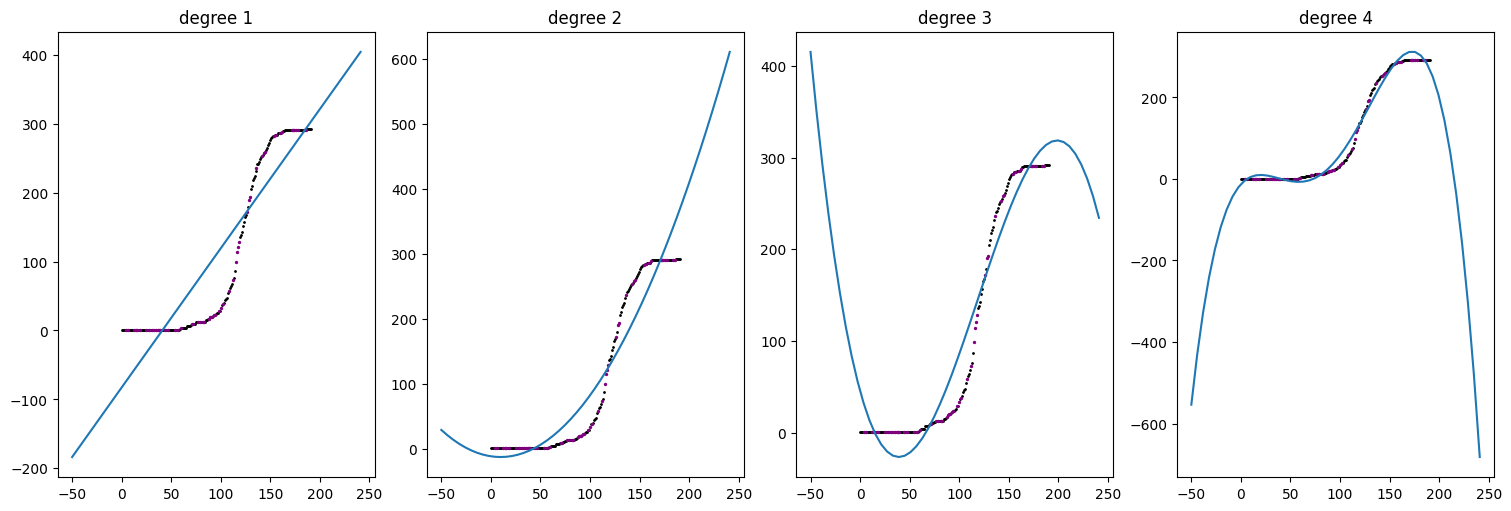

In [14]:
# Retrieve original data
train_X = jnp.array(train_data['time'].values.astype(np.float64))
train_Y = jnp.array(train_data['clin_signs'].values.astype(np.float64))

test_X = jnp.array(test_data['time'].values.astype(np.float64))
test_Y = jnp.array(test_data['clin_signs'].values.astype(np.float64))   

delta = 50
m = 4
fig, axis = plt.subplots(1, m, figsize=(15, 5), constrained_layout=True) # This allows to do multiples plots in the same figure

for n in range(1, m + 1):
    # Do predictions
    x_pred = linspace(min(all_data["time"]) - delta, max(all_data["time"]) + delta) 
    y_pred =  polynomial_least_squares(train_X, train_Y, x_pred, n)

    r = test_Y - polynomial_least_squares(train_X, train_Y, test_X, n, False)
    squared_error = sum(ri*ri for ri in r)
    mse = squared_error / len(test_Y)
    print(f"Then the mean squared error is {round(mse, 2)}")

    # Plot prediction n at the column n-1
    axis[n - 1].scatter(train_X, train_Y, s=1, color="black", label = "train_data")
    axis[n - 1].scatter(test_X, test_Y, s=2, color="purple", label = "test_data")
    axis[n - 1].plot(x_pred, y_pred, label = f"degree {n} Polynomial aproximation")
    axis[n - 1].set_title(f"degree {n}")

plt.show()

Text(0, 0.5, 'Nuevos Casos')

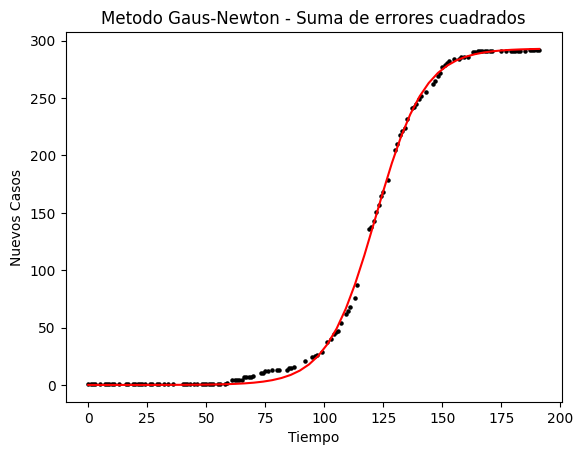

In [15]:
plt.scatter(train_X, train_Y, s = 5, color='black', label = "train_data")
plt.plot(new_X, new_Y_gauss, color='red', label="logistic regression estimation")
plt.title(f"Metodo Gaus-Newton - Suma de errores cuadrados")
plt.xlabel('Tiempo')
plt.ylabel('Nuevos Casos')

## Analysis of Results

### Interpretacion

Una funcion logistica parece ser un buen modelo para el comportamiento del numero acumulado de casos de ebola, por su comportamiento de ser estable al inicio y al final, con un crecimiento rapido en la mitad. Esto se refuerza con el MSE en los datos de prueba de 16.61 que se consiguio y que graficamente se ajusta al comportamiento principal de los datos.

Los resultados al modelar con polinomios dependen del grado del polinomio

- Los polinomios de grado menor que 8 estan en desventaja por que su comportamiento no se ajusta a las etapas inicial y final del brote.

- El polinomio de grado 17 consiguio un MSE en los datos de prueba de 9.14, ademas en varias partes se vuelve indistinguible de la funcion logistica que se obtuvo anteriormente, pero el hecho que siga los pequeños saltos de los datos de forma tan precisa parece indicar overfitting.

Ademas en todos los polinomios al ver el comportamiento en dominios que estan alejados de los datos, estos no tienen sentido, ya que los polinomios explotan y terminan teniendo valores muy negativos o muy positivos, al contrario de la funcion logistica donde al inicio y al final se vuelve estable.

### Calidad de las estimaciones

Se puedo conseguir de manera eficiente computacionalmente una funcion logistica que se ajuste a los datos con un MSE de 16.61, lo cual es una solucion buena y rapida.

En contraste los polinomios de grado menor que 4 no fueron de mucha utilidad, teniendo un MSE bastante mas alto que los otros modelos. A pesar de eso el polinomio de grado 17 consiguio mejor MSE que el conseguido con la funcion logistica, sin embargo tiene las siguientes desventajas.

- Fue mucho mas costoso computacionalmente generar y usar el polinomio de grado 17 que la funcion logistica.
- Ya con el polinomio de grado 18 se tuvo problemas de overflow, lo cual indica cierto riesgo de overflow para el polinomio de grado 17 para su uso en otros datos.
- El polinomio de grado 17 tiende a seguir muy bien los pequeños saltos que tienen los datos, lo cual parece indicar overfitting.

Como resultado los polinomios de alto grado terminan siendo costosos computacionalmente, tiene riesgos de overfitting y overflow, mientras que la funcion logistica se calculo rapidamente y obtuvo buenos resultados.

### Posibles Mejoras

- Usar el dataset de otro brote de ebola para crear una funcion que minizen el MSE entre los datos de ambos brotes, esto con el objetivo de que el modelo sea aplicable a diferentes casos de brotes de ebola, aunque se tendria que ajustar los metodos o buscar alternativas para permitir puntos que repitan el tiempo.

- Se ha mencionado sobre que el comportamiento de los brotes de ebola tiene una etapa inicial y final que es estable, con una fase de crecimiento rapido en la mitad, podria valer la pena dividir los datos de estas 3 etapas y tratar de modelar cada etapa independientemente con polinomios.

- Los modelos SEIR estan diseñados en enfermades contagiosas[4], y contienen informacion especifica de estas enfermadedes en forma de ecuaciones diferenciales que se puedan intentar resolver con metodos numericos, por lo que puede ser mejor modelo del comportamiento del brote de ebola.


## Bibliografia

1. Centers for Disease Control and Prevention (CDC). [Ebola Outbreaks](https://www.cdc.gov/ebola/outbreaks/index.html). Accessed January 12, 2025.
2. Dellicour, S., & Gilbert, M. (n.d.). *SimBIID: Simulation of Births, Immigration, and Deaths in Infectious Disease Epidemiology*. [R Package Documentation](https://cran.r-project.org/web/packages/SimBIID/SimBIID.pdf). Accessed January 12, 2025.
3. Burden, R. L., Faires, J. D., & Burden, A. M. (2015). *Numerical Analysis* (10th ed.). Cengage Learning.
4. [Compartmental models in epidemiology - The SEIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model)